<a href="https://www.kaggle.com/code/pedrovinciusmeerholz/petr4-stocks-forecasting-with-lstm?scriptVersionId=110527854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import MinMaxScaler

## The Dataset

In [2]:
stocks_df = pd.read_csv('../input/ibovespa-stocks/b3_stocks_1994_2020.csv')
stocks_df.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


## Selecting the PETR4 ticker

In [3]:
petr4_df = stocks_df[stocks_df['ticker'] == 'PETR4']
petr4_df.head()

,datetime,ticker,open,close,high,low,volume
209606,1998-03-16,PETR4,276.0,275.0,276.0,273.99,27078933.9
209805,1998-03-17,PETR4,275.0,277.0,278.0,274.50,41049029.3
210027,1998-03-18,PETR4,277.0,275.5,279.0,275.00,40506405.9
210261,1998-03-19,PETR4,275.5,275.5,277.0,272.00,29801256.4
210497,1998-03-20,PETR4,277.0,279.0,280.0,276.00,26713421.3


In [4]:
data = petr4_df['close']
len(data)

5640

## X and y data

In [5]:
forecasting_period = 5

In [6]:
def df_to_X_y(df):
  df = df.to_numpy()
  x = []
  y = []
  for i in range(len(df) - forecasting_period):
    row = [[a] for a in df[i:i+5]]
    x.append(row)
    label = df[i+5]
    y.append(label)
  return np.array(x), np.array(y)

In [7]:
X, y = df_to_X_y(data)
X.shape, y.shape

((5635, 5, 1), (5635,))

In [8]:
train_size = round(len(data) * 0.8)
test_and_val_size = (len(data) - train_size) / 2
train_size, test_and_val_size

(4512, 564.0)

In [9]:
X_train, y_train = X[:4512], y[:4512]
X_val, y_val = X[4512:5076], y[4512:5076]
X_test, y_test = X[5076:], y[5076:]

In [10]:
X_train.shape, X_val.shape, X_test.shape

((4512, 5, 1), (564, 5, 1), (559, 5, 1))

In [11]:
y_train.shape, y_val.shape, y_test.shape

((4512,), (564,), (559,))

## LSTM

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(5, 1)))
model.add(LSTM(units=64))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

2022-11-09 17:22:32.136082: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.save('PETR4-LSTM.h5')

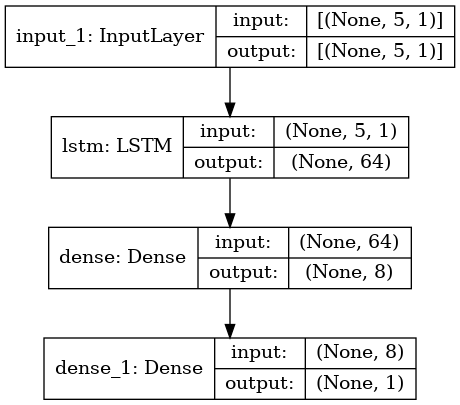

In [15]:
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
checkpoint = ModelCheckpoint('model/', save_best_only=True)

In [17]:
model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

In [18]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=12, callbacks=[checkpoint])

2022-11-09 17:22:33.862136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
141/141 [==============================] - 3s 9ms/step - loss: 11727.7061 - root_mean_squared_error: 108.2945 - val_loss: 0.3567 - val_root_mean_squared_error: 0.5972


2022-11-09 17:22:39.224697: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/12
141/141 [==============================] - 1s 4ms/step - loss: 8602.7432 - root_mean_squared_error: 92.7510 - val_loss: 0.2977 - val_root_mean_squared_error: 0.5456
Epoch 3/12
141/141 [==============================] - 1s 4ms/step - loss: 6618.6577 - root_mean_squared_error: 81.3551 - val_loss: 0.6406 - val_root_mean_squared_error: 0.8004
Epoch 4/12
141/141 [==============================] - 1s 4ms/step - loss: 5025.4443 - root_mean_squared_error: 70.8904 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5003
Epoch 5/12
141/141 [==============================] - 1s 5ms/step - loss: 3677.5608 - root_mean_squared_error: 60.6429 - val_loss: 9.8134 - val_root_mean_squared_error: 3.1326
Epoch 6/12
141/141 [==============================] - 1s 4ms/step - loss: 2603.4446 - root_mean_squared_error: 51.0240 - val_loss: 0.5287 - val_root_mean_squared_error: 0.7271
Epoch 7/12
141/141 [==============================] - 1s 4ms/step - loss: 1823.2972 - root_mean_squared_error: 42.7001 -

In [19]:
model = load_model('model/')

## Train results plot

In [20]:
predict = model.predict(X_train)

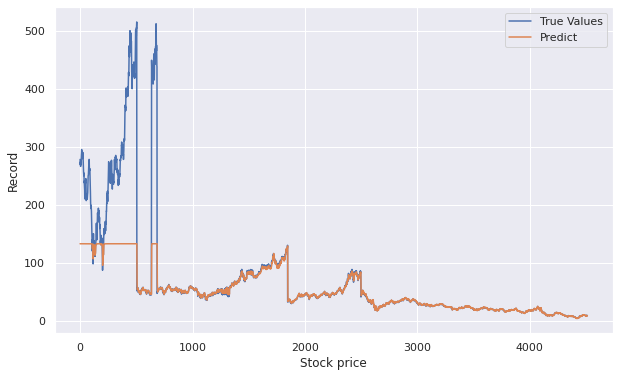

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.plot(y_train, label='True Values')
plt.plot(predict, label='Predict')
plt.xlabel('Stock price')
plt.ylabel('Record')
plt.legend()
plt.show()

## Test results plot

In [22]:
test_predict = model.predict(X_test)

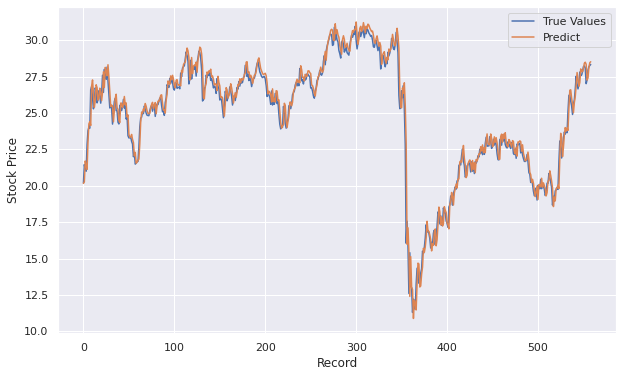

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(test_predict, label='Predict')
plt.xlabel('Record')
plt.ylabel('Stock Price')
plt.legend()
plt.show()